<a href="https://colab.research.google.com/github/Tanushreea05/Stock-Price-Prediction/blob/main/DL_EXP_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [4]:
df_train = pd.read_csv('/content/trainset.csv')
df_test = pd.read_csv('/content/testset.csv')


In [5]:
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [6]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [7]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)


In [8]:

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [9]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [10]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
      out, h_n = self.rnn(x)
      out = self.fc(out[:, -1, :])
      return out

In [12]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
!pip install torchinfo

In [14]:
from torchinfo import summary

# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 64]              12,608
├─Linear: 1-2                            [64, 1]                   65
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.02
Forward/backward pass size (MB): 1.97
Params size (MB): 0.05
Estimated Total Size (MB): 2.03

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [16]:
epochs = 20
model.train()
train_losses=[]
for epoch in range(epochs):
  epoch_loss = 0
  for x_batch, y_batch in train_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    output = model(x_batch)
    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  train_losses.append(epoch_loss/len(train_loader))
  print(f"Epoch [{epoch+1}/{epoch}], Loss: {train_losses[-1]:.4f}")

Epoch [1/0], Loss: 0.1235
Epoch [2/1], Loss: 0.0520
Epoch [3/2], Loss: 0.0428
Epoch [4/3], Loss: 0.0359
Epoch [5/4], Loss: 0.0286
Epoch [6/5], Loss: 0.0186
Epoch [7/6], Loss: 0.0069
Epoch [8/7], Loss: 0.0009
Epoch [9/8], Loss: 0.0007
Epoch [10/9], Loss: 0.0006
Epoch [11/10], Loss: 0.0006
Epoch [12/11], Loss: 0.0006
Epoch [13/12], Loss: 0.0006
Epoch [14/13], Loss: 0.0006
Epoch [15/14], Loss: 0.0006
Epoch [16/15], Loss: 0.0006
Epoch [17/16], Loss: 0.0006
Epoch [18/17], Loss: 0.0006
Epoch [19/18], Loss: 0.0005
Epoch [20/19], Loss: 0.0005


Name:Tanushree A
Reg No:212223100057


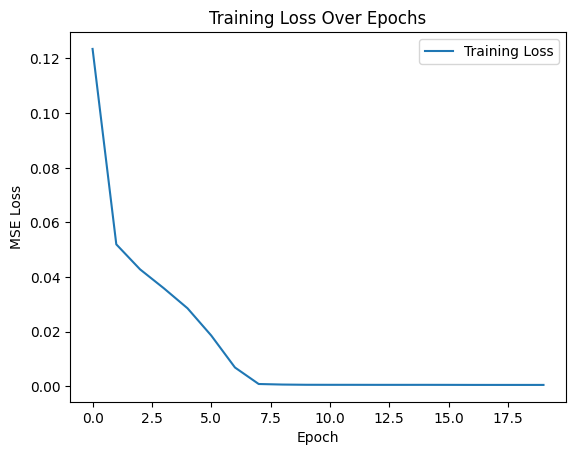

In [17]:
print('Name:Tanushree A')
print('Reg No:212223100057')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Name:Tanushree A
Reg No:212223100057


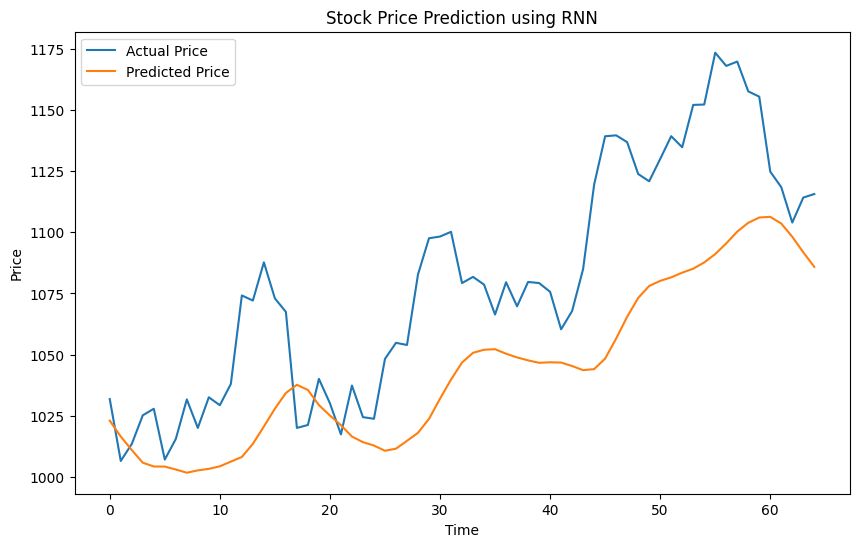

Predicted Price: [1085.8616]
Actual Price: [1115.65]


In [18]:
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
print('Name:Tanushree A')
print('Reg No:212223100057')
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')